In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import pickle

In [2]:
df = pd.read_csv('./../Datasets/hospital_readmissions.csv')

diag_cols = [col for col in ['diag_1', 'diag_2', 'diag_3'] if col in df.columns]

most_common_diag = df[df['diag_1'] != 'Missing']['diag_1'].mode()[0]
for col in diag_cols:
    df[col] = df[col].replace('Missing', most_common_diag)


# Step 1: Replace 'Other' if another diag column has specific value
def resolve_other(row):
    diags = [row[col] for col in diag_cols]
    specific_diags = [d for d in diags if d != 'Other']
    if len(specific_diags) == 0:
        return None  # Flag for deletion
    new_diags = []
    for d in diags:
        if d == 'Other':
            # Replace with first available specific diagnosis
            new_diags.append(specific_diags[0])
        else:
            new_diags.append(d)
    return pd.Series(new_diags, index=diag_cols)
def convert_age(age_str):
    try:
        if '-' in age_str:
            parts = age_str.replace('[', '').replace(')', '').split('-')
            return (int(parts[0]) + int(parts[1])) // 2
        else:
            return np.nan
    except:
        return np.nan
# Apply resolution
resolved_diag = df.apply(resolve_other, axis=1)
df[diag_cols] = resolved_diag

# Drop rows where all 3 diagnoses were 'Other'
df.dropna(subset=diag_cols, inplace=True)

def count_unique_diagnoses(row):
    diags = set([row[col] for col in diag_cols if row[col] != 'Other' and row[col] != 'Missing'])
    return len(diags)


def plotgraph(content, title, ylabel, xlabel):
    plt.figure(figsize=(12, 6))
    content.plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    return

In [3]:
#fetures
age_weights = {
    '[40-50)': 1, '[50-60)': 2,
    '[60-70)': 3, '[70-80)': 4, '[80-90)': 5, '[90-100)' : 6
}
diagnosis_weight = {
    'Circulatory' : 2, 'Respiratory' : 1.7, 'Diabetes' : 1, 'Digestive' : 0.8, 'Injury': 0.5, 'Musculoskeletal' : 0.7
}

df['age_weighted'] = df['age'].map(age_weights)
df['age'] = df['age'].map(age_weights)
df['NumberofDiagnosis'] = df.apply(count_unique_diagnoses, axis=1)
df['total_visits'] = df['n_inpatient'] + df['n_outpatient']
df['age_emergency_visits'] = df['n_emergency'] * df['age']
df['age_total_visits'] = df['age'] * df['total_visits']
df['age_time_in_hospital'] = df['age'] * df['time_in_hospital']
df['age_NumberofDiagnosis'] = df['age'] * df['NumberofDiagnosis']

df['diag_1'] = df['diag_1'].map(diagnosis_weight)
df['age_diagnosis'] = df['age'] * df['diag_1']
df['age_medication'] = df['age'] * df['n_medications']
df['age_time_in_hospital_medication'] = df['time_in_hospital'] * df['age_medication']
readmit_counts = df['readmitted'].value_counts()

df['readmitted'] = df['readmitted'].map({'yes': 1, 'no': 0})


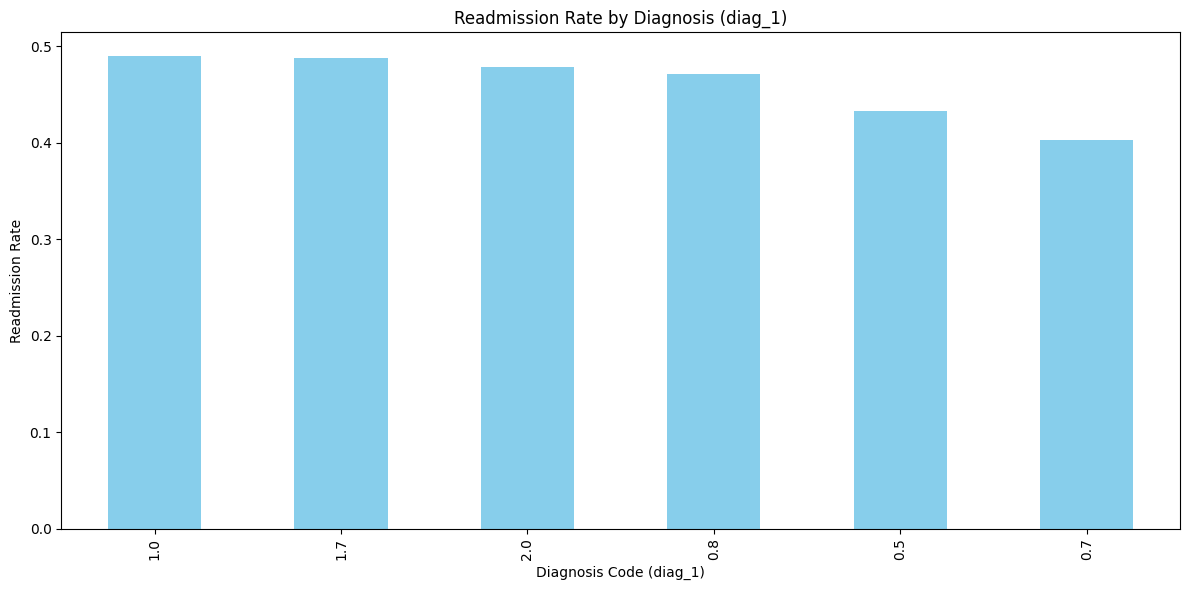

diag_1
1.0    0.489705
1.7    0.487613
2.0    0.478048
0.8    0.470695
0.5    0.432946
0.7    0.402857
Name: readmitted, dtype: float64


In [4]:
readmission_rate_by_diag = df.groupby('diag_1')['readmitted'].mean().sort_values(ascending=False)
plotgraph(readmission_rate_by_diag, 'Readmission Rate by Diagnosis (diag_1)', 'Readmission Rate',  'Diagnosis Code (diag_1)')
print(readmission_rate_by_diag)



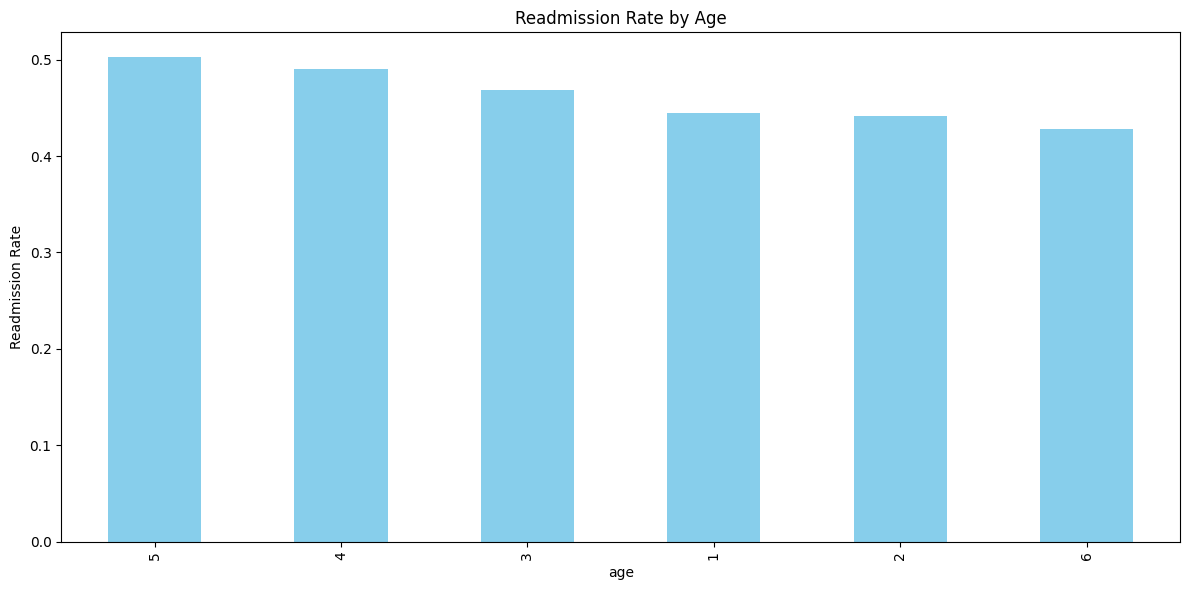

In [5]:
readmission_rate_by_age = df.groupby('age')['readmitted'].mean().sort_values(ascending=False)
plotgraph(readmission_rate_by_age, 'Readmission Rate by Age','Readmission Rate' , 'age')



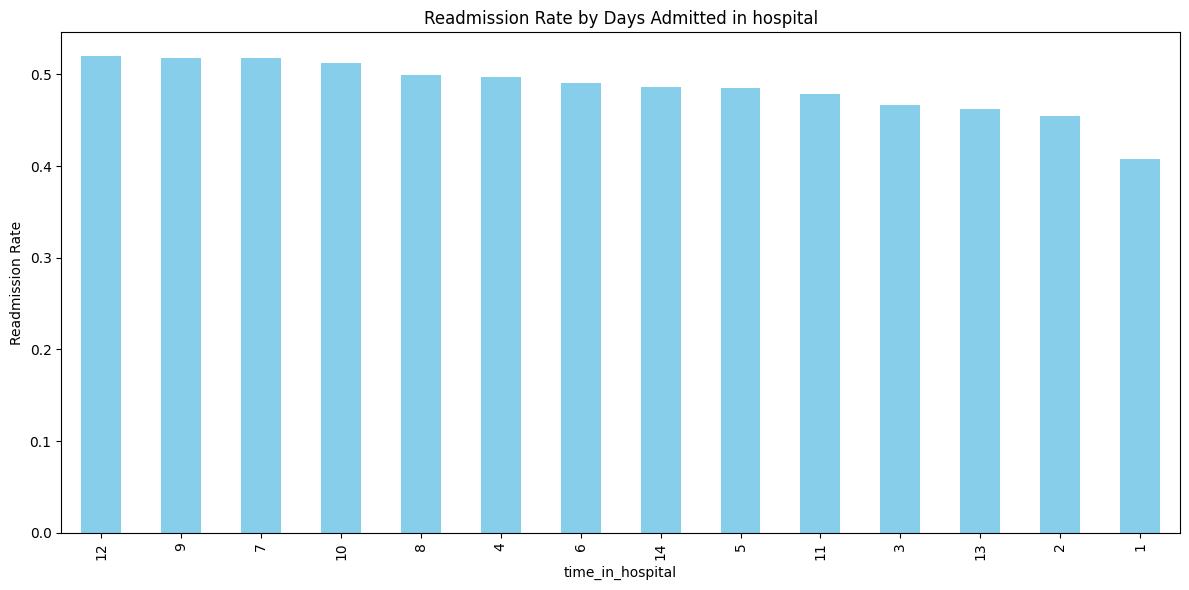

time_in_hospital
12    0.519878
9     0.518258
7     0.517699
10    0.512868
8     0.499020
4     0.497541
6     0.490857
14    0.486486
5     0.485498
11    0.479115
3     0.466451
13    0.462687
2     0.454858
1     0.407750
Name: readmitted, dtype: float64


In [6]:
readmission_rate_by_time_in_hospital = df.groupby('time_in_hospital')['readmitted'].mean().sort_values(ascending=False)
plotgraph(readmission_rate_by_time_in_hospital, 'Readmission Rate by Days Admitted in hospital', 'Readmission Rate', 'time_in_hospital')

print(readmission_rate_by_time_in_hospital)

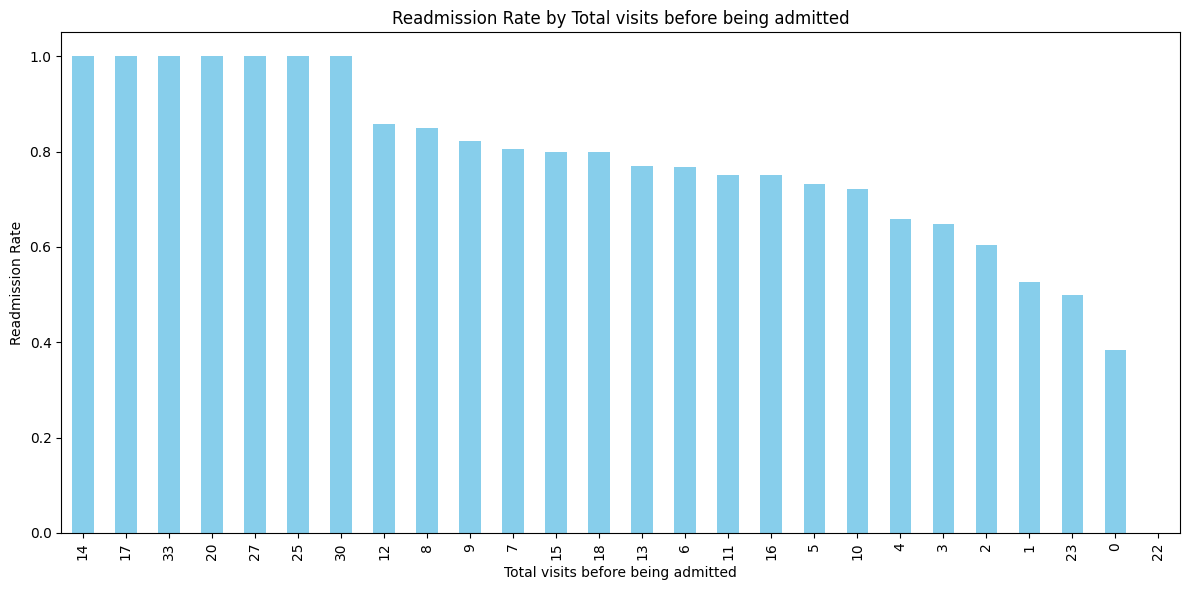

total_visits
14    1.000000
17    1.000000
33    1.000000
20    1.000000
27    1.000000
25    1.000000
30    1.000000
12    0.857143
8     0.848837
9     0.822581
7     0.805755
15    0.800000
18    0.800000
13    0.769231
6     0.767068
11    0.750000
16    0.750000
5     0.732468
10    0.720930
4     0.659325
3     0.649050
2     0.604435
1     0.525825
23    0.500000
0     0.384243
22    0.000000
Name: readmitted, dtype: float64


In [7]:
readmission_rate_by_totalVisits = df.groupby('total_visits')['readmitted'].mean().sort_values(ascending=False)
plotgraph(readmission_rate_by_totalVisits,'Readmission Rate by Total visits before being admitted','Readmission Rate','Total visits before being admitted')
print(readmission_rate_by_totalVisits)

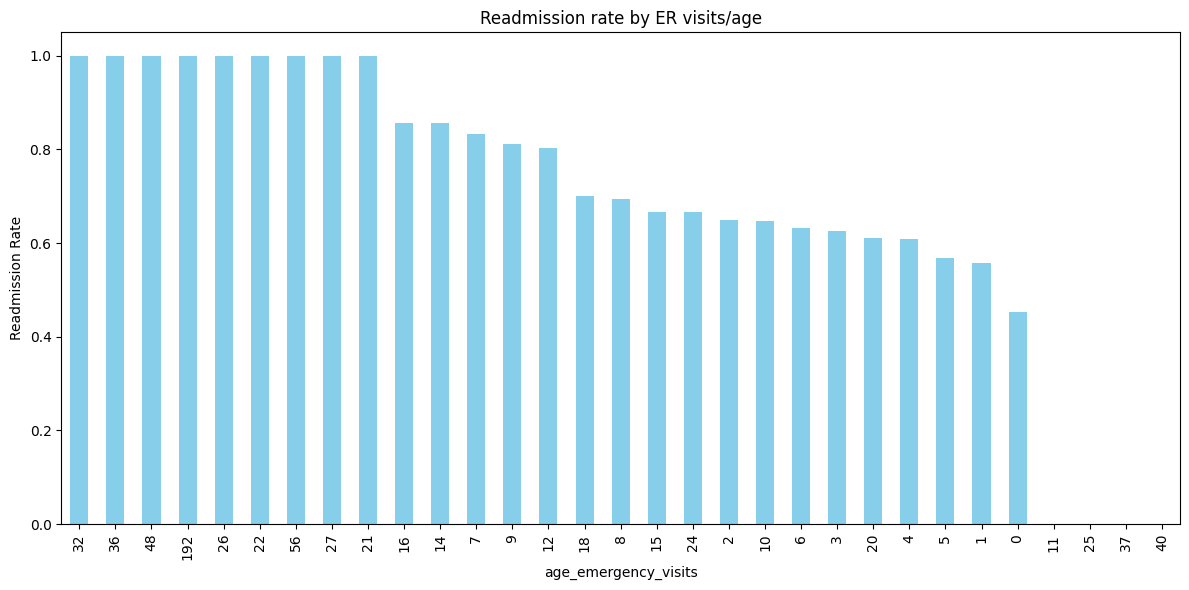

age_emergency_visits
32     1.000000
36     1.000000
48     1.000000
192    1.000000
26     1.000000
22     1.000000
56     1.000000
27     1.000000
21     1.000000
16     0.857143
14     0.857143
7      0.833333
9      0.812500
12     0.803030
18     0.700000
8      0.693431
15     0.666667
24     0.666667
2      0.649616
10     0.647059
6      0.631579
3      0.626566
20     0.611111
4      0.608303
5      0.567123
1      0.557377
0      0.453536
11     0.000000
25     0.000000
37     0.000000
40     0.000000
Name: readmitted, dtype: float64


In [8]:
readmission_rate = df.groupby('age_emergency_visits')['readmitted'].mean().sort_values(ascending=False)
plotgraph(readmission_rate, 'Readmission rate by ER visits/age', 'Readmission Rate', 'age_emergency_visits')
print(readmission_rate)

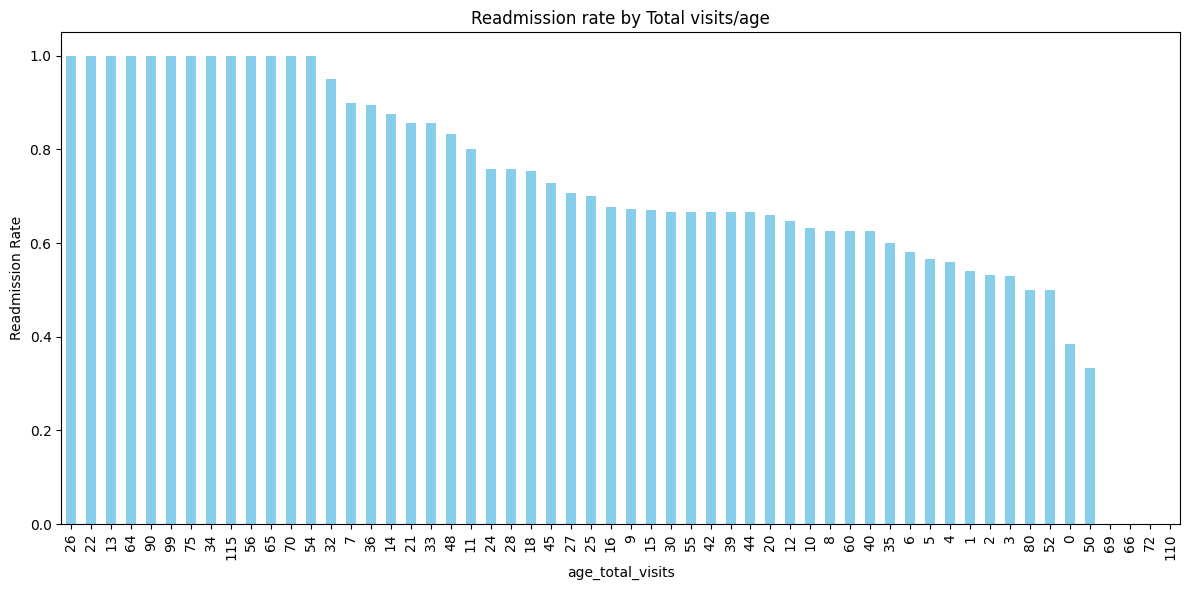

age_total_visits
26     1.000000
22     1.000000
13     1.000000
64     1.000000
90     1.000000
99     1.000000
75     1.000000
34     1.000000
115    1.000000
56     1.000000
65     1.000000
70     1.000000
54     1.000000
32     0.950000
7      0.900000
36     0.894737
14     0.875000
21     0.857143
33     0.857143
48     0.833333
11     0.800000
24     0.757895
28     0.757576
18     0.754386
45     0.727273
27     0.705882
25     0.701493
16     0.676724
9      0.672131
15     0.669782
30     0.666667
55     0.666667
42     0.666667
39     0.666667
44     0.666667
20     0.660305
12     0.647841
10     0.631193
8      0.625683
60     0.625000
40     0.625000
35     0.600000
6      0.580717
5      0.565591
4      0.558669
1      0.540816
2      0.530852
3      0.530190
80     0.500000
52     0.500000
0      0.384243
50     0.333333
69     0.000000
66     0.000000
72     0.000000
110    0.000000
Name: readmitted, dtype: float64


In [9]:
readmission_rate = df.groupby('age_total_visits')['readmitted'].mean().sort_values(ascending=False)
plotgraph(readmission_rate, 'Readmission rate by Total visits/age', 'Readmission Rate', 'age_total_visits')
print(readmission_rate)

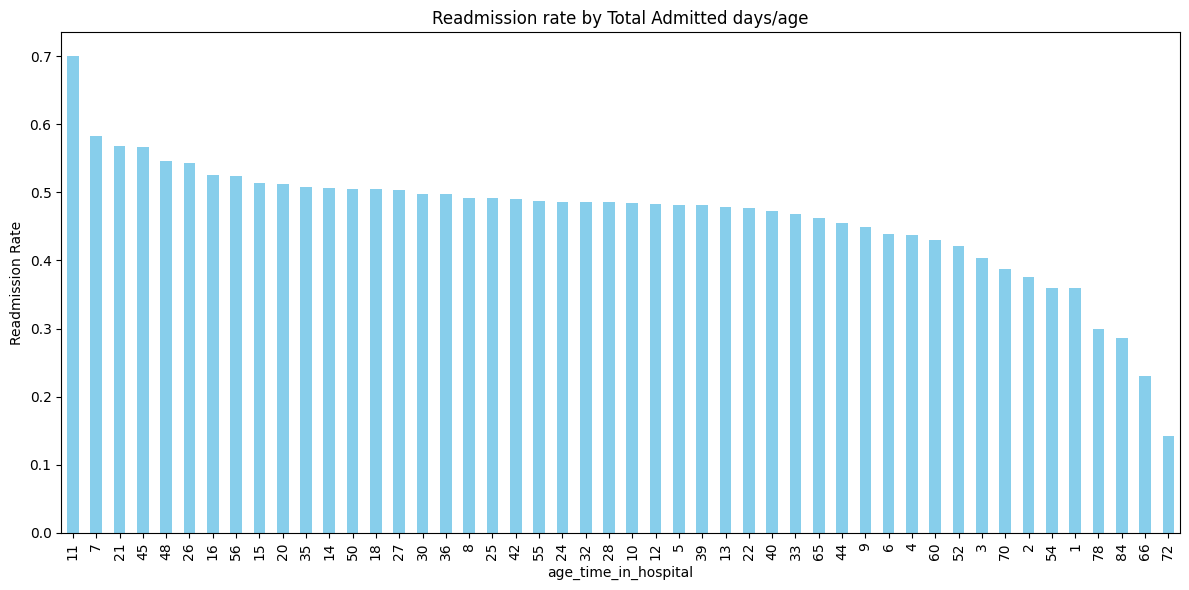

age_time_in_hospital
11    0.700000
7     0.582677
21    0.567742
45    0.566265
48    0.545455
26    0.543478
16    0.525501
56    0.523810
15    0.513575
20    0.511611
35    0.507353
14    0.506550
50    0.505155
18    0.504601
27    0.502890
30    0.497427
36    0.497024
8     0.491814
25    0.491228
42    0.490909
55    0.487805
24    0.486517
32    0.486486
28    0.486047
10    0.484221
12    0.483492
5     0.481775
39    0.480769
13    0.478261
22    0.477612
40    0.472678
33    0.468085
65    0.462963
44    0.454545
9     0.449692
6     0.438699
4     0.437434
60    0.430556
52    0.421687
3     0.404120
70    0.388060
2     0.376147
54    0.360000
1     0.359155
78    0.300000
84    0.285714
66    0.230769
72    0.142857
Name: readmitted, dtype: float64


In [10]:
readmission_rate = df.groupby('age_time_in_hospital')['readmitted'].mean().sort_values(ascending=False)
plotgraph(readmission_rate, 'Readmission rate by Total Admitted days/age', 'Readmission Rate', 'age_time_in_hospital')
print(readmission_rate)

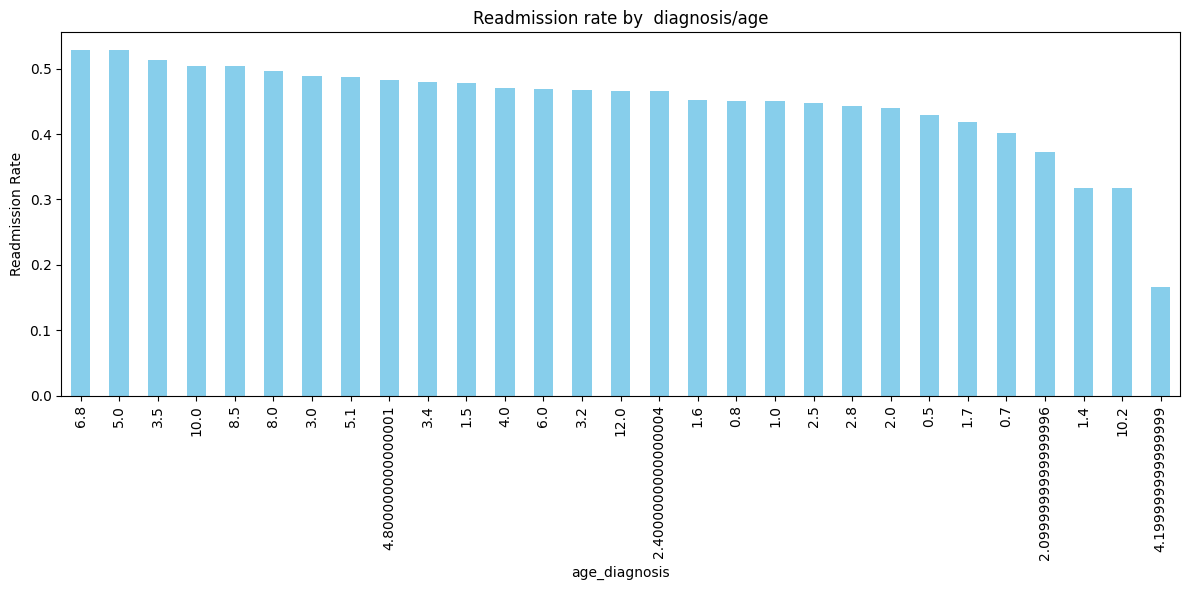

age_diagnosis
6.8     0.529055
5.0     0.528767
3.5     0.513228
10.0    0.504611
8.5     0.503488
8.0     0.496798
3.0     0.488340
5.1     0.487329
4.8     0.483146
3.4     0.479755
1.5     0.477974
4.0     0.470191
6.0     0.469321
3.2     0.467153
12.0    0.466463
2.4     0.465257
1.6     0.452107
0.8     0.451220
1.0     0.450837
2.5     0.446866
2.8     0.442857
2.0     0.439830
0.5     0.428571
1.7     0.418919
0.7     0.401786
2.1     0.371921
1.4     0.318008
10.2    0.316901
4.2     0.166667
Name: readmitted, dtype: float64


In [11]:
readmission_rate = df.groupby('age_diagnosis')['readmitted'].mean().sort_values(ascending=False)
plotgraph(readmission_rate, 'Readmission rate by  diagnosis/age', 'Readmission Rate', 'age_diagnosis')
print(readmission_rate)

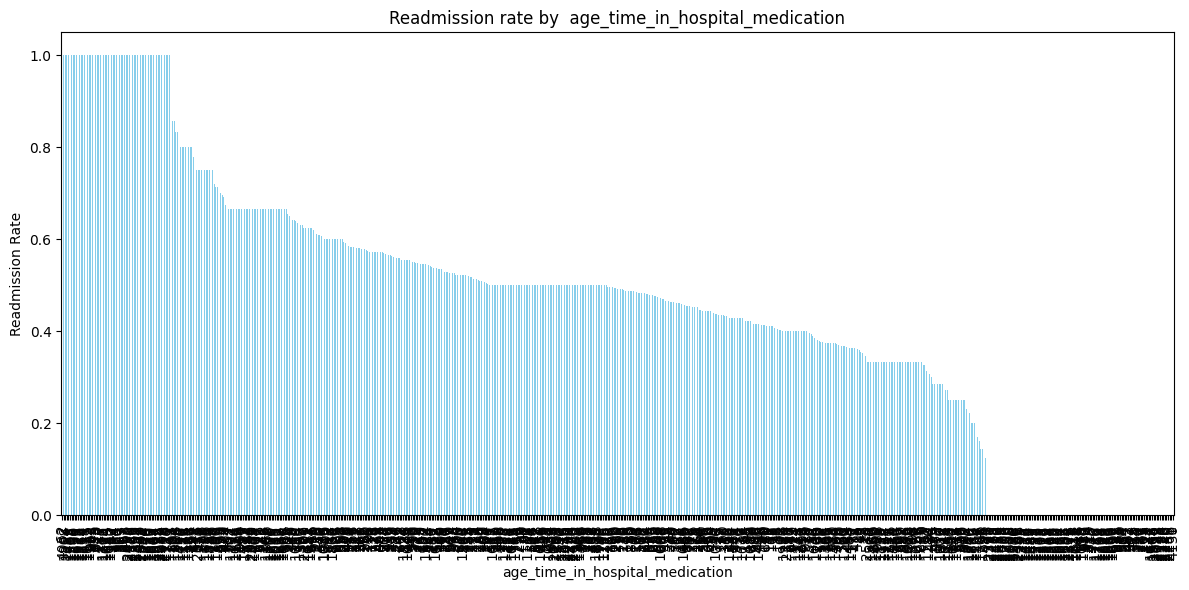

age_time_in_hospital_medication
62      1.0
4032    1.0
3808    1.0
1254    1.0
1482    1.0
       ... 
2240    0.0
2250    0.0
2268    0.0
1       0.0
4130    0.0
Name: readmitted, Length: 695, dtype: float64


In [12]:
readmission_rate = df.groupby('age_time_in_hospital_medication')['readmitted'].mean().sort_values(ascending=False)
plotgraph(readmission_rate, 'Readmission rate by  age_time_in_hospital_medication', 'Readmission Rate', 'age_time_in_hospital_medication')
print(readmission_rate)

In [13]:
features = ['age_time_in_hospital','age_time_in_hospital_medication', 'age_diagnosis',  'age_emergency_visits', 'age_total_visits']

X = df[features]
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
model = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=10,            # depth of each tree
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight='balanced', # handle imbalance
    random_state=42
)
model.fit(X_train_sm, y_train_sm)
y_proba = model.predict_proba(X_test)[:, 1]
threshold = 0.5
y_pred_custom = (y_proba >= threshold).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_custom))
print("\nClassification Report:\n", classification_report(y_test, y_pred_custom))
print("Accuracy:", accuracy_score(y_test, y_pred_custom))
print('AUC-ROC:', round(roc_auc_score(y_test, y_proba)*100))



Confusion Matrix:
 [[1682  748]
 [1052 1205]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.69      0.65      2430
           1       0.62      0.53      0.57      2257

    accuracy                           0.62      4687
   macro avg       0.62      0.61      0.61      4687
weighted avg       0.62      0.62      0.61      4687

Accuracy: 0.6159590356304673
AUC-ROC: 64


In [ ]:
metadata = {
    'features': features
}

with open('./model/readmission_model.pkl', 'wb') as f:
    pickle.dump({'model': model, 'metadata': metadata}, f)

print("\nModel saved with clinical priority weights:")


Model saved with clinical priority weights:


                           Feature  Importance
4                 age_total_visits    0.351024
1  age_time_in_hospital_medication    0.250575
2                    age_diagnosis    0.168933
0             age_time_in_hospital    0.134340
3             age_emergency_visits    0.095128


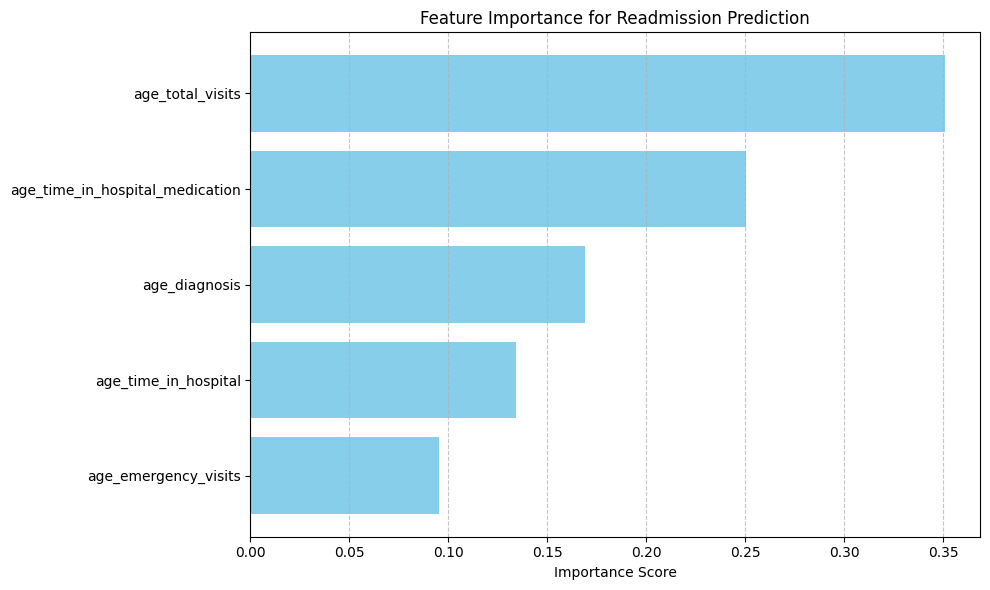

In [15]:
importances = model.feature_importances_

# Create DataFrame of feature importances
feature_importance_df = pd.DataFrame({
    'Feature': X_train_sm.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


# Display and plot feature importance
print(feature_importance_df)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Importance Score")
plt.title("Feature Importance for Readmission Prediction")
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()